### Transcribing legato slurs from hard onset detection and ScoreCloud

In [1]:
# Autoload libraries
%load_ext autoreload
%autoreload 2

# External libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import madmom
import mir_eval
from IPython.display import Audio
from music21 import *

# Pre- and postprocessing
from modules.analysis_funcs import get_segmented_data, get_test_peaks
# Dataset handler
from datasets import Dataset
# Model
from models import FINAL_MODEL_PATH
# Visualization functions
from modules.vis import onset_visualizer, passage_extractor, slur_visualizer, piano_roll_mat
# Evaluation
from analyze_detection import evaluate

# Suppress TF logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


/home/simonf/.venv/onsets/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


### 1. Audio data

In [2]:
# Link to tensorflow model
MODEL_PATH = "results/cnn-training-230202f/fold_0_refined-seq-20eps-lr0.0010-standard_model"

# Link to audio and annotation files
# Audio should be wav
# Annotation file should contain onsets in seconds (one on each line, without headers)
#audio_fname = "datasets/slurtest_add/slurtest_add_audio/slurtest05_FK.wav"
audio_fname = "datasets/sturmbach/sturmbach_audio/Violin Partita No. 2 in D Minor, BWV 1004 - IV. Gigue-CygjWBog9mo.mp3"
#label_fname = "datasets/slurtest_add/new_annotations/slurtest05_FK.txt"
label_fname = "datasets/sturmbach/sturmbach_labels/Violin Partita No. 2 in D Minor, BWV 1004 - IV. Gigue-CygjWBog9mo.txt"

#audio, sample_rate = madmom.io.audio.load_wave_file(audio_fname)
audio, sample_rate = madmom.io.audio.load_audio_file(audio_fname)
true_onsets = np.loadtxt(label_fname, usecols=0)
Audio(audio, rate=sample_rate)

In [59]:
# Select how much of the audio to show
begin = 0 # from 
end = 6.5 # until

framerate = 0.01    # The model outputs activations with this frame rate

<AxesSubplot:>

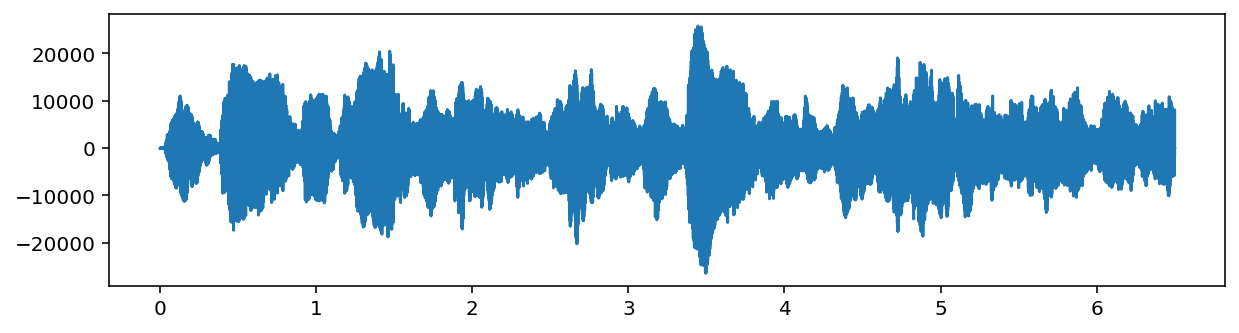

In [60]:
# Plot waveform
fig,ax = plt.subplots(figsize=(10,2.5))
passage = passage_extractor(audio,
        [ # List of onsets goes here
        ],
    [begin, end], # Segment between these seconds to plot
    sr=sample_rate
)[0]

# Function below plots only the content in the passage --- keep fixed
onset_visualizer(passage=passage, ax=ax)

### 2. Onset detection

In [61]:
# Load model - detect onsets

framerate = 0.01    # The model outputs activations with this frame rate
epoch = 16
model = tf.keras.models.load_model(MODEL_PATH, custom_objects = {"wbce": lambda x,y:None})
model.load_weights(MODEL_PATH[:-6]+"_cp_{:04d}.ckpt".format(epoch))
cnn_input = get_segmented_data(audio)
cnn_output = model.predict(cnn_input)
cnn_onsets = get_test_peaks(cnn_output, framerate)
print("Number of onsets detected: ", len(cnn_onsets))

Number of onsets detected:  13


In [9]:
# Evaluate the result (on the full recording)

TOL = 0.025 # seconds of tolerance window
metrics = mir_eval.onset.evaluate(true_onsets, cnn_onsets, window=TOL)
print("F-measure: ", metrics["F-measure"])
print("Precision: ", metrics["Precision"])
print("Recall: ", metrics["Recall"])

F-measure:  0.42105263157894735
Precision:  0.9090909090909091
Recall:  0.273972602739726


<AxesSubplot:>

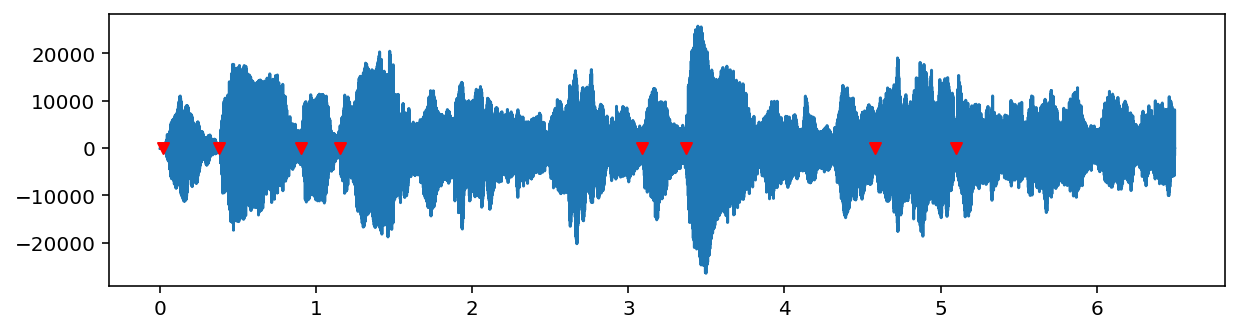

In [63]:
# Plot detections
pred_color = "red"
fig,ax = plt.subplots(figsize=(10,2.5))
passage = passage_extractor(audio,
        [ 
            cnn_onsets      # added here
        ],
    [begin,end],
    sr=sample_rate
)[0]
onset_visualizer(passage=passage, ax=ax, onset_styles={"m":["v"], "c":[pred_color]})

<AxesSubplot:>

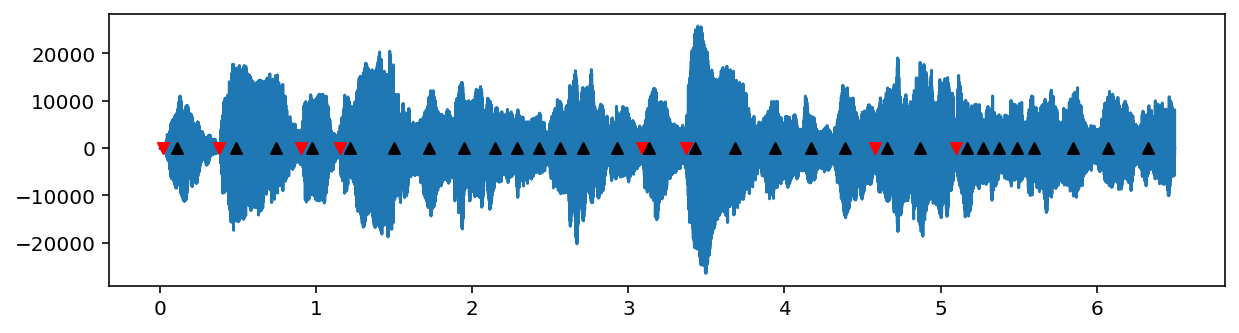

In [64]:
# Plot both detected and true onsets

true_color = "black"
fig,ax = plt.subplots(figsize=(10,2.5))
styles = {"m":["^", "v"], "c":[true_color, pred_color]}
passage = passage_extractor(audio,
        [ 
            true_onsets, 
            cnn_onsets
        ],
    [begin, end], # Segment between these seconds to plot
    sr=sample_rate
)[0]
# Function below plots only the content in the passage
onset_visualizer(passage=passage, ax=ax, onset_styles=styles)

### 3. Note data

In [65]:
# Load and show note data 
# (ScoreCloud intermediate result)
#notes = pd.read_csv("datasets/sc_onsets/" + os.path.basename(audio_fname)[:-4] + ".midi.csv")
#notes = pd.read_csv("datasets/sturmbach/sturmbach_csv_raw/" + os.path.basename(audio_fname)[:-4] + ".csv")
notes = pd.read_csv("datasets/sturmbach/sturmbach_labels/" + os.path.basename(audio_fname)[:-4] + ".midi.csv")

# Remove polyphony for visualization
notes["prev_diff"] = np.concatenate(([np.inf],np.diff(notes["onset"])))
notes = notes[notes["prev_diff"] > 0]
notes[(notes["onset"]>begin) & (notes["offset"]<end)]

,onset,offset,pitch,note,octave,prev_diff
0,0.108000,0.271000,69,A,5,inf
1,0.488723,0.798723,62,D,5,0.380723
2,0.739723,0.948723,65,F,5,0.251000
3,0.974723,1.183723,69,A,5,0.235000
4,1.216630,1.472630,74,D,6,0.241907
5,1.497630,1.692478,76,E,6,0.281000
6,1.720641,1.932536,77,F,6,0.223011
7,1.948630,2.136385,76,E,6,0.227989
8,2.148394,2.278542,79,G,6,0.199764
9,2.286589,2.415335,77,F,6,0.138195


In [73]:
shift = notes.iloc[0]["onset"] - cnn_onsets[0]
print(shift)

0.08800000044703483


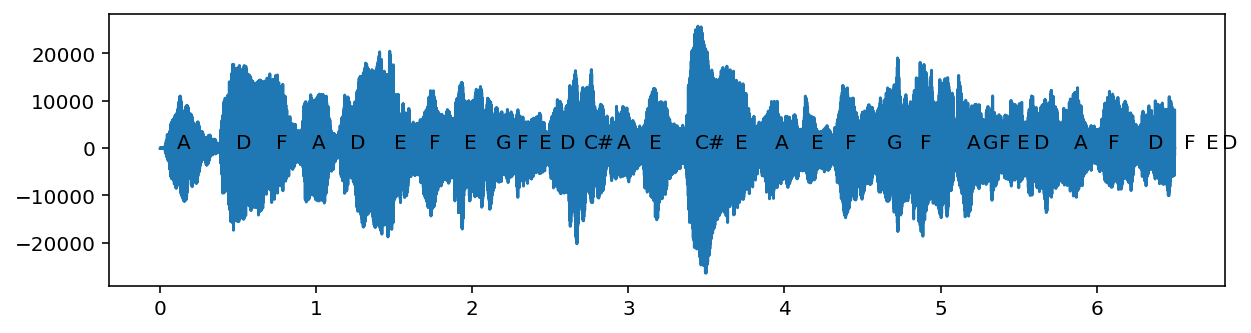

In [68]:
# Show note names in audio
fig,ax = plt.subplots(figsize=(10,2.5))
passage = passage_extractor(audio,
        [ # List of onsets goes here
        ],
    [begin, end], # Segment between these seconds to plot
    sr=sample_rate
)[0]

# Function below plots only the content in the passage --- keep fixed
onset_visualizer(passage=passage, ax=ax)

for note in notes.iloc:
    ax.annotate(text=note["note"], xy=(note["onset"],0))

In [74]:
vis_onsets = np.array([1.0])
fps = int(1/framerate)
n_steps = np.max(notes["offset"]*fps).astype(int)
pr_matrix = np.zeros((n_steps, 128)).astype(bool)
for i, note in enumerate(notes.iloc):
    pr_matrix[np.arange(int(note["onset"]*fps), int(note["offset"]*fps)), note["pitch"]] = True
pr = pr_matrix

In [75]:
vis_onsets = cnn_onsets[(cnn_onsets<end) & (cnn_onsets>begin)] + shift

pr, classified_pr, onset_wins, art_idx = piano_roll_mat(
    notes, 
    vis_onsets, 
    fps=int(1/framerate), slur_tol=0.025
)

Text(0, 0.5, 'MIDI number')

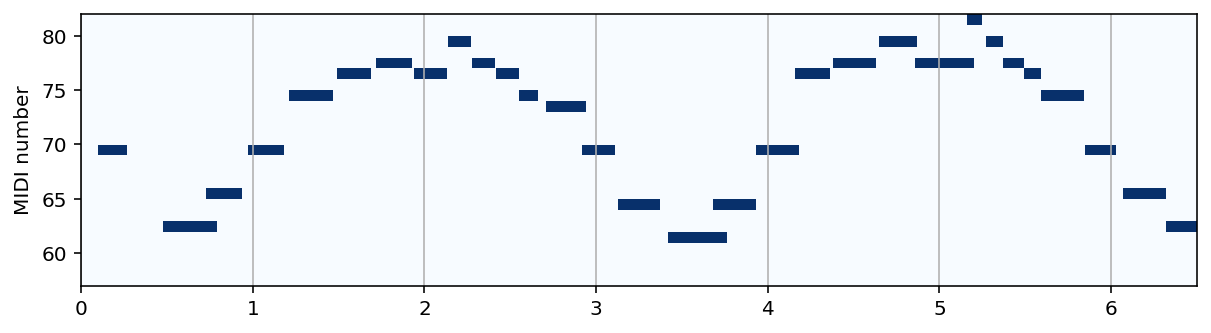

In [76]:
# Visualize as piano roll
FPS = int(1/framerate)
fig,ax = plt.subplots(figsize=(10,2.5))
ax.grid(axis='x')
ax.imshow(
    pr[int(begin*FPS):int(end*FPS), notes["pitch"].min():notes["pitch"].max()].transpose(),
    extent=(begin, end, notes["pitch"].min(),notes["pitch"].max()),
    aspect="auto", origin="lower", interpolation="None", cmap="Blues"
)
ax.set_ylabel("MIDI number")


In [19]:


# Convert list of notes to ABC score
note_seq = notes[(notes["prev_diff"]>0) & (notes["onset"]>begin) & (notes["offset"]<end)]
def tokenizer(r):
    t = r["note"].lower() if r["octave"]>=5 else r["note"].upper()
    t = t + "'" if r["octave"]==6 else t
    return t
token_seq = [tokenizer(r) for r in note_seq.iloc]


In [20]:
# Show ABC score 

abc_str = """
X:1
T:{}
M:4/4
K:C
 {}
""".format(
    os.path.basename(audio_fname),
    " ".join(token_seq)
)
with open("test.abc", "w") as f:
    f.write(abc_str)

abc_score = converter.parse("test.abc")
abc_score.show()

SubConverterFileIOException: /usr/lib/x86_64-linux-gnu/libjack.so.0
/usr/lib/x86_64-linux-gnu/libnss3.so
This application failed to start because it could not find or load the Qt platform plugin "offscreen"
in "".

Available platform plugins are: xcb.

Reinstalling the application may fix this problem.
/tmp/.mount_mscoreDeciAj/AppRun: line 26: 2108182 Aborted                 (core dumped) "${APPDIR}/bin/mscore-portable" "$@"


### 4. Extending score with slurs

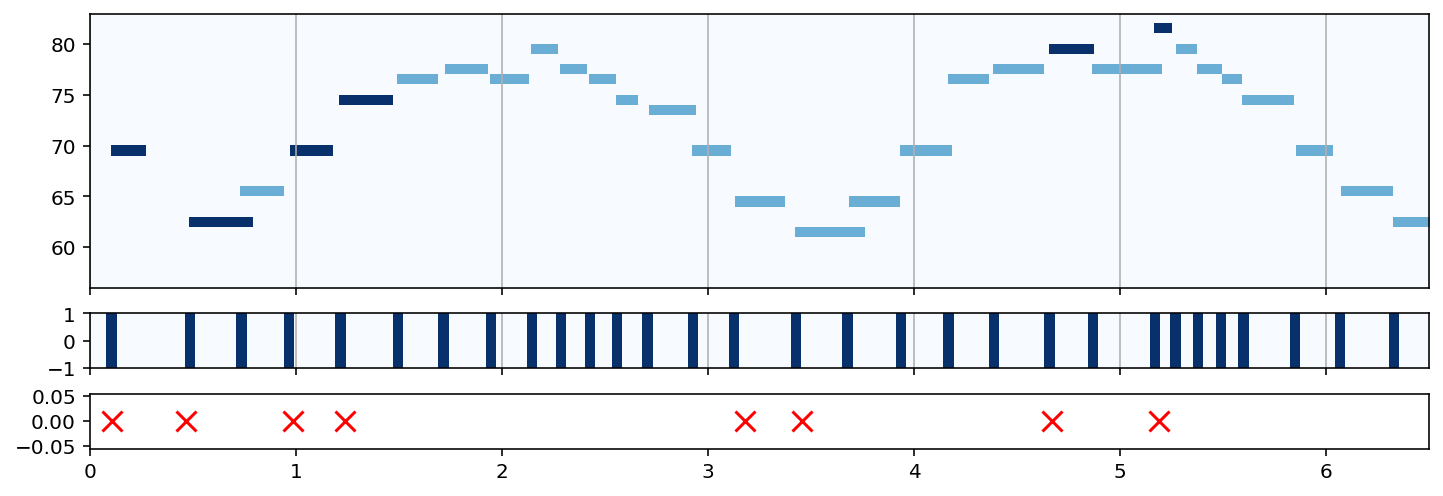

In [77]:
# Match hard onsets against note windows
# Classify notes (
#   articulated shown as dark, 
#   slurred shown as light blue
# )

ymin = np.where(pr==True)[1].min()-1
ymax = np.where(pr==True)[1].max()+1
fig, axs = plt.subplots(3,1,figsize=(12,4), sharex=True, gridspec_kw={'height_ratios': [5, 1, 1]})
#axs[0].text(x=1.1,y=65, s="Piano roll")
axs[0].grid(axis='x')
axs[0].imshow(
    classified_pr[int(begin*FPS):int(end*FPS), ymin:ymax].transpose(), 
    extent=(begin, end, ymin, ymax),
    aspect='auto', 
    origin="lower", 
    interpolation='none', 
    cmap='Blues'
)
#axs[1].text(x=1.1,y=0.0, s="Note onset window")
axs[1].grid(axis='x')
axs[1].imshow(
    onset_wins[int(begin*FPS):int(end*FPS), :].transpose(), 
    extent=(begin, end, -1, 1),
    aspect='auto', 
    origin="lower", 
    interpolation='none',
    cmap='Blues'
)
#axs[2].text(x=1.1,y=0.0, s="Hard onsets")
axs[2].scatter(
    vis_onsets, 
    np.zeros(len(vis_onsets)),
    marker="x",
    s=100,
    c="r"
)

In [105]:
# Extracting start- and end positions of slurs given articulated notes
sos = art_idx[np.where(np.diff(art_idx)>1)[0]]
eos = art_idx[np.where(np.diff(art_idx)>1)[0]][1:] - 1
slurred_token_seq = ["("+t if i in sos else (t+")" if i in eos else t) for i,t in enumerate(token_seq)]


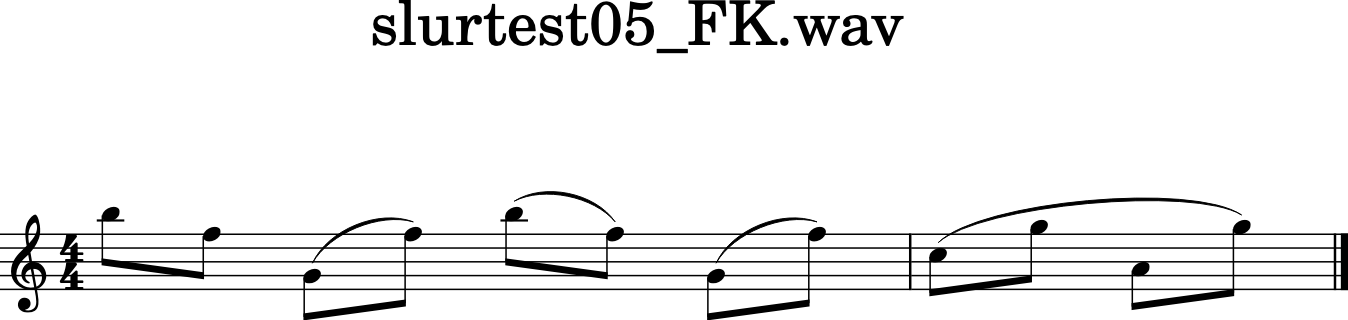

In [106]:
# Finally, show score with slurs

abc_str = """
X:1
T:{}
M:4/4
K:C
 {}
""".format(
    os.path.basename(audio_fname),
    " ".join(slurred_token_seq)
)
with open("test.abc", "w") as f:
    f.write(abc_str)

abc_score = converter.parse("test.abc")
abc_score.show()
